In [1]:
from IPython.display import Image

# 強化學習Cartpole (pytorch)

In [2]:
# Figure 1
Image(url="Images/polecart.gif", width=300, height=300)


**Goal**

訓練的目的就是希望台車能夠學會正確的移動，好讓木棒持續停留在平衡位置。如果用RL的術語來說，目標就是要找尋 _策略_ $a$, 藉由與環境的互動(讓木棒保持平衡)好讓 _獎賞_ $r$ 最大化。於是給定一系列的實驗 $$s \xrightarrow{a} r, s'$$ 讓後讓智能體學會在給定的狀態下 $s$ 找出最佳的行動策略 $a$ 以將跨時間累積獎賞最大化 $r$ :

$$
Q(s,a) = r_0 + \gamma r_1 + \gamma^2 r_2 + \ldots = r_0 + \gamma \max_a Q^*(s',a)
$$

此處的 $\gamma \in [0,1)$ 是用來控制評估獎賞的折價因子，我們也稱之為 [*Bellmann*-equation](https://en.wikipedia.org/wiki/Bellman_equation).

在接下來的範例中，我們將示範如何針對狀態空間建模，以及如何根據收到的獎賞，來轉化為取得未來最大獎賞的行動。

在此我們將採用兩種常見的技術:

**Deep Q-Networks (DQN)**: DQNs在2015年只透過遊戲畫面像素數據就能訓練智能體玩Atari電動遊戲而聲名大噪。我們訓練神經網路學習 $Q(s,a)$ 值 (也就是 $Q$-Network )。根據這 $Q$ 函數直，我們可以選擇最佳策略。

**Policy gradient (策略梯度)**: 這個方法是在神經網路中直接估計策略(行動組合)，結果是學習一組有序的動作，通過機率選擇動作的子集來最大化獎勵。 

請注意，由於這個實作的目的是為了要理解RL的概念，因此我們網路部分都使用簡單的淺層網路，當然這個部分是可以日後再擴充與使用結構更複雜的網路。

In [3]:
from __future__ import print_function
from __future__ import division
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pandas as pd
import seaborn as sns

style.use('ggplot')
%matplotlib inline

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

執行實作前需要安裝 OpenAI gym包

In [4]:
try:
    import gym
except:
    !pip install gym
    import gym

## CartPole: 數據與環境

我們將使用OpenAI's [gym](https://github.com/openai/gym)模擬器中的[CartPole](https://gym.openai.com/envs/CartPole-v0)環境以訓練台車學會維持木棒的平衡。

在每個時間點, 智能體(agent)
 * 取得環境觀察值 $(x, \dot{x}, \theta, \dot{\theta})$, 分別表示 *台車位置*, *台車速度*, *木棒對垂直交角*, *木棒角速度(落下速度)*,
 * 採取行動 `向左` 或 `向右`, 以及
 * 獲得
  * 每多存活一刻就會獲得獎賞 +1 
  * 新狀態 $(x', \dot{x}', \theta', \dot{\theta}')$

如果觸發以下條件，則episode終止
 * 木棒距垂直角度大於15度
 * 臺車移動距離中心超過2.4個單位

任務完成認定條件
 * 智能體在過去50個episodes期間累積獎賞值200以上


## 方法1: DQN

在每次轉換後 $(s,a,r,s')$, 我們試圖將我們的價值函數 $Q(s,a)$ 移近我們的目標 $r+\gamma \max_{a'}Q(s',a')$, 其中 $\gamma$ 是未來獎勵的折扣因子，值介於0和1之間。

DQNs
 * 學習能將觀察 (狀態, 行動)對應至 `score`的 _Q-函數_ 
 * 使用記憶體重放（以前記錄的 $Q$ 值對應不同的 $(s,a)$ 來解相關經驗（序列狀態轉換）


### Model: DQN

$$
l_1 = relu( x W_1 + b_1) \\
Q(s,a) = l_1 W_2 + b_2 \\
$$

來源參考自Keras版本實現, https://github.com/jaara/AI-blog/blob/master/CartPole-basic.py, 作者是Jaromír Janisch 首見於他的 [AI blog](https://jaromiru.com/2016/09/27/lets-make-a-dqn-theory/)

我們使用簡單的兩層全連接層網路來做練習。

In [5]:
import math
import random
import numpy as np
import argparse
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from torch.distributions import Bernoulli
from itertools import count


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

STATE_COUNT = 4 (corresponding to $(x, \dot{x}, \theta, \dot{\theta})$),

ACTION_COUNT = 2 (corresponding to `LEFT` or `RIGHT`)

In [6]:
env = gym.make('CartPole-v0').unwrapped

STATE_COUNT  = env.observation_space.shape[0]
ACTION_COUNT = env.action_space.n

STATE_COUNT, ACTION_COUNT

(4, 2)

In [7]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

 `記憶(Memory)` 類別是用來儲存不同的狀態、行動以及獎賞

In [8]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)

    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.bn1(self.conv1(x)))
        #print(x.shape)
        x = F.relu(self.bn2(self.conv2(x)))
        #print(x.shape)
        x = F.relu(self.bn3(self.conv3(x)))
        #print(x.shape)
        return self.head(x.view(x.size(0), -1))

`智能體` 使用 `Brain` 以及 `Memory` 來重放(replay)過去的行動以選擇能讓獎賞最大化的行動集合。

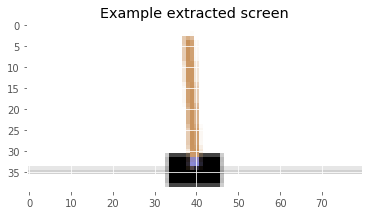

In [9]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

# This is based on the code from gym.
screen_width = 600


def get_cart_location():
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART


def get_screen():
    screen = env.render(mode='rgb_array').transpose(
        (2, 0, 1))  # transpose into torch order (CHW)
    # Strip off the top and bottom of the screen
    screen = screen[:, 160:320]
    view_width = 320
    cart_location = get_cart_location()
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescare, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

### 訓練

如何一般的學習過程，我們希望一開始的行動可以較具探索性，然後隨著學習過程逐漸掌握哪些行動比較夠獲得較高報酬。 The tutorial below implements the [epsilon-greedy](https://en.wikipedia.org/wiki/Reinforcement_learning) approach (a.k.a. $\epsilon$-greedy). 

In [ ]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(2)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see http://stackoverflow.com/a/19343/3343043 for
    # detailed explanation).
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

num_episodes = 3000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Update the target network
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.ioff()
plt.show()


<Figure size 600x400 with 0 Axes>

## 方法 2: 策略梯度 (PG, Policy gradient)
**目標:**
$$
\text{maximize } E [R | \pi_\theta]
$$

**思路:**
1. 收集經驗 (透過 $(s,a)$ 空間，取樣一系列的軌跡)
2. 更新策略，讓好 _good_ 經驗變得更有可能

**與DQN的差異:**
 * 不用考慮單一 $(s,a,r,s')$ 轉換,而在梯度更新時考慮整個episodes
 * 模型參數直接對策略建模(輸出是行動的機率),而DQN是針對價值函數建模(輸出是原始分數)

### 獎賞

停留在遊戲中的每多一刻，獎賞+1

問題: 我們通常一開始不知道, 甚麼樣的行動可以讓遊戲玩久一點。簡單的思路：在批次開始時的動作很好，而那些最終的動作可能很糟糕（畢竟他們導致了遊戲失敗）。

In [ ]:
def discount_rewards(r, gamma=0.999):
    """使用1D rewards向量以及計算折價後獎賞 """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [ ]:
discounted_epr = discount_rewards(np.ones(10))
f, ax = plt.subplots(1, figsize=(5,2))
sns.barplot(list(range(10)), discounted_epr, color="steelblue")

In [ ]:
discounted_epr_cent = discounted_epr - np.mean(discounted_epr)
discounted_epr_norm = discounted_epr_cent/np.std(discounted_epr_cent)
f, ax = plt.subplots(1, figsize=(5,2))
sns.barplot(list(range(10)), discounted_epr_norm, color="steelblue")

In [ ]:
discounted_epr = discount_rewards(np.ones(10), gamma=0.5)
discounted_epr_cent = discounted_epr - np.mean(discounted_epr)
discounted_epr_norm = discounted_epr_cent/np.std(discounted_epr_cent)
f, ax = plt.subplots(2, figsize=(5,3))
sns.barplot(list(range(10)), discounted_epr, color="steelblue", ax=ax[0])
sns.barplot(list(range(10)), discounted_epr_norm, color="steelblue", ax=ax[1])

### Model: Policy Gradient

$$
l_1 = relu( x W_1 + b_1) \\
l_2 = l_1 W_2 + b_2 \\
\pi(a|s) = sigmoid(l_2)
$$

請注意: 在使用策略梯度法時,全連接層的輸出要加上sigmoid，以轉換為0~1之間。

In [ ]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(STATE_COUNT, 24)
        self.fc2 = nn.Linear(24, 36)
        self.fc3 = nn.Linear(36, 1)  # Prob of Left

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x



### 執行 PG 模型

**策略搜索(Policy Search)**: 最優策略搜索可以使用無梯度方法或通過計算由$ \ theta $參數化的策略空間（$ \ pi_ \ theta $）上的梯度下降來執行。在本實作中, 我們在參數化空間 $\theta$使用經典正向 (`loss.forward`) 和反向 (`loss.backward`) 傳播方式處理偏差。在這案例中, $\theta = \{W_1, b_1, W_2, b_2\}$, 也就是我們的模型參數。  


In [ ]:
episode_durations = []
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.FloatTensor(episode_durations)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        plt.pause(0.001)  # pause a bit so that plots are updated

# Parameters
num_episode =10000
batch_size =  50
learning_rate = 0.01
gamma = 0.99


env = gym.make('CartPole-v0').unwrapped
policy_net = PolicyNet()
optimizer = torch.optim.RMSprop(policy_net.parameters(), lr=learning_rate)


In [ ]:
# Batch History
state_pool = []
action_pool = []
reward_pool = []
steps = 0


for e in range(num_episode):
    state  = env.reset()
    state = torch.from_numpy(state).float()
    state = Variable(state)
    for t in count():
        probs = policy_net(state)
        m = Bernoulli(probs)
        action = m.sample()

        action = action.data.numpy().astype(int)[0]
        next_state, reward, done, _ = env.step(action)
        

        # To mark boundarys between episodes
        if done:
            reward = 0
        else:
            env.render()

        state_pool.append(state)
        action_pool.append(float(action))
        reward_pool.append(reward)

        state = next_state
        state = torch.from_numpy(state).float()
        state = Variable(state)

        steps += 1

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
        else:
            env.render()
            

    # Update policy
    if e > 0 and e % batch_size == 0:
        # Discount reward
        running_add = 0
        for i in reversed(range(steps)):
            if reward_pool[i] == 0:
                running_add = 0
            else:
                running_add = running_add * gamma + reward_pool[i]
                reward_pool[i] = running_add

        # Normalize reward
        reward_mean = np.mean(reward_pool)
        reward_std = np.std(reward_pool)
        for i in range(steps):
            reward_pool[i] = (reward_pool[i] - reward_mean) / reward_std

        # Gradient Desent
        optimizer.zero_grad()
        print('Episode: %d. Average reward for episode %f.' % (e ,reward_mean))
        for i in range(steps):
            state = state_pool[i]
            action = Variable(torch.FloatTensor([action_pool[i]]))
            reward = reward_pool[i]

            probs = policy_net(state)
            m = Bernoulli(probs)
            loss = -m.log_prob(action) * reward  # Negtive score function x reward
            loss.backward()

        optimizer.step()

        state_pool = []
        action_pool = []
        reward_pool = []
        steps = 0